In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import heapq
import random
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
from scipy import signal
import matplotlib.image as mpimg
import math

# Chargement

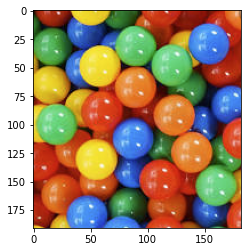

In [11]:
file = 'boules.png'
img = Image.open(file)
image = np.asarray(img)
plt.imshow(image)

# Recadrage

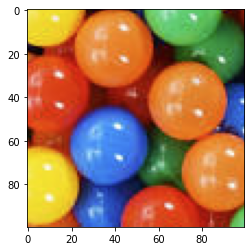

In [12]:
image = Image.fromarray(image.astype(np.uint8))
xmin, ymin, xmax, ymax = 50, 50, 150, 150
image = image.crop((xmin, ymin, xmax, ymax))
plt.imshow(image)

# Flou

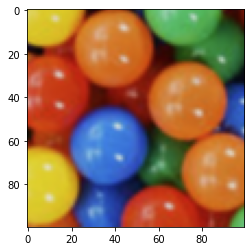

In [13]:
image = np.asarray(image)
#flou = mpimg.imread('montgolfiere.jpg')[:,:,:3]
gauss_kernel = gaussian_kernel(k=1, s=0.8)
for i in range(3):
    image[:,:,i] = signal.convolve2d(image[:,:,i], gauss_kernel, boundary='symm', mode='same')
plt.imshow(image)
image = Image.fromarray(image)

# Enregistrement

In [14]:
image.save('image.png', format='png')
file = 'image.png'

# Graph

In [15]:
graph = graph_from_image(file) #vérifier avoir enregistrer l'image à traiter au préalable

100%|██████████| 100/100 [00:00<00:00, 545.79it/s]


Ici j'ajouterais le graphe d'une image suffisament simple pour que son graphe soit observable facilement. 
cf: graphe_image_simple.ipynb

# Segmentation

  0%|          | 0/39600 [00:00<?, ?it/s]

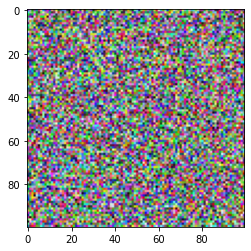

  9%|▉         | 3711/39600 [00:05<00:58, 613.65it/s] 

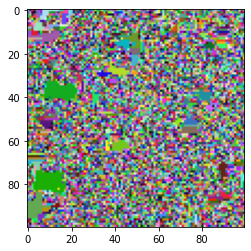

 18%|█▊        | 7221/39600 [00:10<00:45, 713.42it/s] 


KeyboardInterrupt: 

In [16]:
E = graph.graph
width = image.size[0]
height = image.size[1]
V = np.arange(width*height) 
segmented_img = np.zeros((width, height, 3), dtype=np.uint8)

E.sort(key=lambda e: e[2])
segmented_img = np.zeros((width, height, 3), dtype=np.uint8)

    # 1. Start with a segmentation S0, where each vertex vi is in its own component
S = [[v] for v in V]
    
    # 2. Repeat step 3 for q = 1, . . . , m
    
for q in tqdm(range(len(E))):
    (vi, vj, w) = E[q]
    Ci = Cj = None
    for i in range(len(S)):
        if vi in S[i]:
            Ci = i
        if vj in S[i]:
            Cj = i
        if Ci is not None and Cj is not None:
            break
    #print("w=",w, "S[Ci]=",S[Ci], "S[Cj]=",S[Cj],"diff = ", internal_difference(S[Ci], S[Cj]))
    if Ci != Cj and w <= internal_difference(S[Ci], S[Cj]): 
        S[Ci] += S[Cj]
        del S[Cj]
    if q % 4000 == 0: 
        colors = generate_colors(len(S))
        for i in range(len(S)):
            color = colors[i]
            for v in S[i]:
                segmented_img[v%width,v//height] = color
        plt.imshow(segmented_img)
        plt.show()

In [ ]:
Image1 sans cython : 1min11 pour 75% 

# Autre image

In [ ]:
file = 'scene.png'
img = Image.open(file)
image = np.asarray(img)
image = Image.fromarray(image.astype(np.uint8))
plt.imshow(image)

In [ ]:
xmin, ymin, xmax, ymax = 50, 0, 250, 200
image = image.crop((xmin, ymin, xmax, ymax))
plt.imshow(image)

In [ ]:
image = np.asarray(image)
gauss_kernel = gaussian_kernel(k=1, s=0.8)
for i in range(3):
    image[:,:,i] = signal.convolve2d(image[:,:,i], gauss_kernel, boundary='symm', mode='same')
plt.imshow(image)
image = Image.fromarray(image)
image.save('image.png', format='png')
file = 'image.png'
graph = graph_from_image(file) #vérifier avoir enregistrer l'image à traiter au préalable

In [ ]:
E = graph.graph
width = image.size[0]
height = image.size[1]
V = np.arange(width*height) 
segmented_img = np.zeros((width, height, 3), dtype=np.uint8)

E.sort(key=lambda e: e[2])
segmented_img = np.zeros((width, height, 3), dtype=np.uint8)

    # 1. Start with a segmentation S0, where each vertex vi is in its own component
S = [[v] for v in V]
    
    # 2. Repeat step 3 for q = 1, . . . , m
    
for q in tqdm(range(len(E))):
    (vi, vj, w) = E[q]
    Ci = Cj = None
    for i in range(len(S)):
        if vi in S[i]:
            Ci = i
        if vj in S[i]:
            Cj = i
        if Ci is not None and Cj is not None:
            break
    #print("w=",w, "S[Ci]=",S[Ci], "S[Cj]=",S[Cj],"diff = ", internal_difference(S[Ci], S[Cj]))
    if Ci != Cj and w <= internal_difference(S[Ci], S[Cj]): 
        S[Ci] += S[Cj]
        del S[Cj]
    if q % 4000 == 0: 
        colors = generate_colors(len(S))
        for i in range(len(S)):
            color = colors[i]
            for v in S[i]:
                segmented_img[v%width,v//height] = color
        plt.imshow(segmented_img)
        plt.show()

Image2 sans cython : 29min pour 90% 

# Avec Cython

In [ ]:
%load_ext Cython

In [ ]:
%%cython
import numpy as np
cimport numpy as cnp
import tqdm 
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import heapq
import random
from tqdm import tqdm

def segmentation_algorithm_c(cnp.ndarray[cnp.int_t, ndim=1] V, cnp.ndarray[cnp.double_t, ndim=2] E, int width, int height):
    
    cdef int m = E.shape[0]
    cdef cnp.ndarray[cnp.uint8_t, ndim=3] segmented_img = np.zeros((width, height, 3), dtype=np.uint8)  

    # 1. Start with a segmentation S0, where each vertex vi is in its own component
    S = [[v] for v in V]
    
    # 2. Repeat step 3 for q = 1, . . . , m
    for q in tqdm(range(m)):
        (vi,vj,w) = E[q]
        #print("q=",q,"vi=",vi,"vj=", vj,"w=", w)
        Ci = Cj = None
        for i in range(len(S)):
            if vi in S[i]:
                Ci = i
            if vj in S[i]:
                Cj = i
            if Ci is not None and Cj is not None:
                break
        if Ci != Cj and w <= internal_difference_c(S[Ci], S[Cj]):
            S[Ci] += S[Cj]
            del S[Cj]
        if q % 4000 == 0: 
            colors = generate_colors_c(len(S))
            for i in range(len(S)):
                color = colors[i]
                for v in S[i]:
                    segmented_img[v % width, v // height] = color
            plt.imshow(segmented_img)
            plt.show()

    return S

def generate_colors_c(n):
    colors = []
    for i in range(n):
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        color = (red, green, blue)
        colors.append(color)
    return colors

def internal_difference_c(list Ci, list Cj):
    diff_sum = 0
    for vi in Ci:
        for vj in Cj:
            diff_sum += abs(vi - vj)
    return diff_sum / (len(Ci) * len(Cj))


In [ ]:
graph = graph_from_image(file) #vérifier avoir enregistrer l'image à traiter au préalable
E = graph.graph
E = np.array(sorted(E,key=lambda e: e[2]))
width = image.size[0]
height = image.size[1]
V = np.arange(width*height) 

In [ ]:
segmentation_algorithm_c(V,E,width,height)

In [ ]:
Image1 avec cython : 6min44 pour 75% 

# Fonctions

In [ ]:
def gaussian_kernel(k, s = 0.8):
    # generate a (2k+1)x(2k+1) gaussian kernel with mean=0 and sigma = s
    probs = [math.exp(-z*z/(2*s*s))/math.sqrt(2*math.pi*s*s) for z in range(-k,k+1)]
    return np.outer(probs, probs)

class Graph:
    def __init__(self, V):
        self.V = V 
        self.graph = []
        
    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])
        
    def find_parent(self, parent, i):
        if parent[i] == i:
            return i
        return self.find_parent(parent, parent[i])
    
    def union(self, parent, rank, x, y):
        root_x = self.find_parent(parent, x)
        root_y = self.find_parent(parent, y)
        
        if rank[root_x] < rank[root_y]:
            parent[root_x] = root_y
        elif rank[root_x] > rank[root_y]:
            parent[root_y] = root_x
        else:
            parent[root_y] = root_x
            rank[root_x] += 1
    
    def chazelle_mst(self):
        # Créer une liste pour stocker les arêtes de l'arbre couvrant minimal
        mst = []
        
        # Créer un dictionnaire pour stocker le degré aléatoire de chaque sommet
        degrees = {i: random.random() for i in range(self.V)}
        
        # Trier les arêtes en ordre décroissant de leur degré aléatoire
        sorted_edges = sorted(self.graph, key=lambda edge: degrees[edge[0]], reverse=True)
        
        # Créer un tableau pour stocker les parents de chaque sommet
        parent = [i for i in range(self.V)]
        # Créer un tableau pour stocker les rangs de chaque ensemble
        rank = [0 for _ in range(self.V)]
        
        # Pour chaque arête triée,
        # fusionner les ensembles contenant les sommets de l'arête si nécessaire
        for u, v, w in sorted_edges:
            root_u = self.find_parent(parent, u)
            root_v = self.find_parent(parent, v)
            
            if root_u != root_v:
                mst.append((u, v, w))
                self.union(parent, rank, root_u, root_v)
        
        return mst

    def kruskal_mst(self):
        result = []
        i = 0 
        e = 0 #nombre d'arrêtes
        parent = []
        rank = []

        # Initialisation de parent et rank pour chaque nœud du graphe
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
            
        # Tri des bords en fonction de leur poids (troisième élément)
        self.graph = sorted(self.graph, key=lambda item: item[2])
        
        # Parcours des bords triés
        while e < self.V - 1:
            # Récupération des informations sur le prochain bord
            u, v, w = self.graph[i]
            i = i + 1

            # Recherche du parent de u et de v
            x = self.find_parent(parent, u)
            y = self.find_parent(parent, v)

            # Si u et v n'ont pas le même parent, on peut ajouter l'arête au mst
            if x != y:
                e = e + 1
                result.append([u, v, w])
                # Union des deux sous-arbres enracinés à x et y
                self.union(parent, rank, x, y)

        # Calcul du coût total de l'arbre de recouvrement minimum
        mst_cost = sum([i[2] for i in result])
        # Retourne le coût et les arêtes de l'arbre de recouvrement minimum
        return mst_cost, result
    

     
def graph_from_image(image):
    img = Image.open(image).convert("RGB")
    width, height = img.size
    pixels = img.load()

    V = width * height # autant de sommets que de pixels
    graph = Graph(V)

    for i in tqdm(range(width)):
        for j in range(height):
            pixel = pixels[i, j]

            #on récupère les voisins de chaque pixels
            neighbors = []
            if i > 0:
                neighbors.append((i-1, j))
            if i < width-1:
                neighbors.append((i+1, j))
            if j > 0:
                neighbors.append((i, j-1))
            if j < height-1:
                neighbors.append((i, j+1))

            for n in neighbors:
                neighbor_pixel = pixels[n[0], n[1]] #récupère les valeurs RGB du pixel voisin
                weight = np.sqrt(sum((np.array(pixel) - np.array(neighbor_pixel))**2)) #distance euclidienne selon les valeurs RGB

                u = i * height + j #indice du pixel de base
                v = n[0] * height + n[1] #indice du pixel voisin
                graph.add_edge(u, v, weight)

    return graph

In [ ]:
def internal_difference(Ci, Cj):
    diff_sum = 0
    for vi in Ci:
        for vj in Cj:
            diff_sum += abs(vi - vj)
    return diff_sum / (len(Ci) * len(Cj))

In [ ]:
def generate_colors(n):
    colors = []
    for i in range(n):
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        color = (red, green, blue)

        colors.append(color)
    return colors